## Packages

In [1]:
import numpy as np
import math
import shapely
import geopandas as gpd
import pandas as pd
import fiona # https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal, pip install shapely, pip install geopandas, https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona, 
import matplotlib.pyplot as plt

## User Defined Functions

In [2]:
def splits_to_regions_binary(row, splits):
    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

## Data

In [3]:
pa_bg = gpd.read_file('../data/geography/pa/cbg_shapefile')
voting_pop = pd.read_csv("../data/population/pa/pop.csv")
voting_pop['GEOID'] = voting_pop['GEO_ID'].apply(lambda x: x.split("US")[1])
pa_bg = pa_bg.merge(voting_pop, on="GEOID")

pa_bg.to_crs("EPSG:2271")
pa_bg['REPRESENTATIVE_POINT'] =  pa_bg.representative_point() # https://gis.stackexchange.com/a/414263
pa_bg['RP_LON'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_bg['RP_LAT'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(pa_bg.shape)
pa_bg.sample(n=5)

(10173, 19)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_ID,NAME,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT
2669,42,003,414200,4,420034142004,Block Group 4,G5030,S,6093997,0,+40.5722665,-079.9306795,"POLYGON ((-79.95480 40.57288, -79.95480 40.572...",1500000US420034142004,"Block Group 4, Census Tract 4142, Allegheny Co...",1297,POINT (-79.92774 40.56987),-79.927738,40.569865
7540,42,019,911200,2,420199112002,Block Group 2,G5030,S,18579457,59948,+40.8747362,-079.8193943,"POLYGON ((-79.87594 40.88671, -79.87584 40.886...",1500000US420199112002,"Block Group 2, Census Tract 9112, Butler Count...",1515,POINT (-79.82615 40.87196),-79.826147,40.871961
6672,42,071,011102,1,420710111021,Block Group 1,G5030,S,19737848,71221,+40.1053755,-076.5711595,"POLYGON ((-76.61208 40.08865, -76.61125 40.089...",1500000US420710111021,"Block Group 1, Census Tract 111.02, Lancaster ...",849,POINT (-76.56921 40.09905),-76.569208,40.099045
7800,42,091,204002,3,420912040023,Block Group 3,G5030,S,2302012,16452,+40.1135923,-075.3155732,"POLYGON ((-75.32692 40.10521, -75.32678 40.105...",1500000US420912040023,"Block Group 3, Census Tract 2040.02, Montgomer...",1826,POINT (-75.31502 40.11403),-75.315019,40.114029
3476,42,027,011101,4,420270111014,Block Group 4,G5030,S,619137,0,+40.9173784,-077.7667897,"POLYGON ((-77.77261 40.92294, -77.76950 40.921...",1500000US420270111014,"Block Group 4, Census Tract 111.01, Centre Cou...",714,POINT (-77.76644 40.91783),-77.766443,40.917834


## Rewrite

In [36]:
n_districts = 18
n_split = 1
df = pa_bg.copy()

# Get district ratios:
if n_districts % 2 == 0:
    part_a = n_districts/2
    part_b = n_districts/2
else:
    part_a = math.ceil(n_districts/2)
    part_b = math.floor(n_districts/2)

# Get Total Population
pop_total = df['Population'].sum()

# Get Population Center
pop_center_LON = (df['RP_LON'] * df['Population']).sum()/pop_total
pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/pop_total

# Re-center LAT/LON relative to the Population Center
df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

# Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


## LOOP for d in 0 to 359 ##
start_angles = np.linspace(0,359,360)
# TODO: Remove once choosing logic is ready
start_angles = [90]
# Pick Starting Angle
angle_ranges = []

for d in start_angles:
    # Reset Angle to be Relative to d
    df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
    df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
    df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

    # Spin Clock Around till you achieve the desired ratio
    i = 0
    captured_pop = 0
    while captured_pop < (part_a)/(part_a+part_b)*pop_total:
        captured_pop += df.loc[i, 'Population']
        i += 1
    final_angle = df.loc[i-1, 'RECENTERED_ANGLE']
    angle_ranges.append((d, final_angle))
# TODO: Define logic for comparing partitions, identify most competitive

# TODO: Choose best partitions (pair of angles)
best_angles = angle_ranges[0]

## Check if angle range loops past 360 for conditions:

a1, a2 = best_angles
if a1 < a2:
    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
elif a1 > a2:
    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)



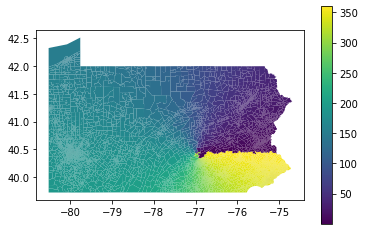

In [63]:
fig, ax = plt.subplots(1, 1)
base = df.plot(column="RECENTERED_ANGLE", ax=ax, legend=True)
plt.show()

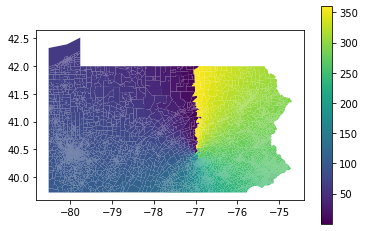

In [64]:
fig, ax = plt.subplots(1, 1)
base = df.plot(column="RESETTED_ANGLE", ax=ax, legend=True)
plt.show()

In [4]:
df[['RECENTERED_LAT', 'RECENTERED_LON', 'RECENTERED_RATIO', 'RECENTERED_ANGLE']].sample(n=5)

NameError: name 'df' is not defined

## Recursive Splitting

In [10]:
holder = []

def split_this(df, n_districts, n_split=1):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df['Population'].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df['Population']).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        # TODO: Remove once choosing logic is ready
        start_angles = [np.random.choice(start_angles)]
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in start_angles:
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, 'Population']
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']
            angle_ranges.append((d, final_angle))
        # TODO: Define logic for comparing partitions, identify most competitive

        # TODO: Choose best partitions (pair of angles)
        best_angles = angle_ranges[0]

        ## Check if angle range loops past 360 for conditions:

        a1, a2 = best_angles
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1)
        split_this(df_b, part_b, n_split=n_split+1)

        
    else:
        holder.append(df)
        
split_this(pa_bg,18)

In [11]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [12]:
all_districts.groupby("DISTRICT").sum()['Population']

DISTRICT
0.0     574486
2.0     575004
4.0     574277
6.0     575983
8.0     574531
10.0    576152
12.0    574752
14.0    574525
15.0    576949
16.0    574282
18.0    574577
20.0    574933
22.0    575504
24.0    573249
26.0    576492
28.0    575884
30.0    575438
31.0    576530
Name: Population, dtype: int64

In [19]:
# Shuffle for coloring
n_districts = 18
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

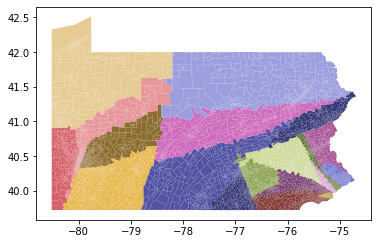

In [20]:
fig, ax = plt.subplots(1, 1)
base = all_districts.plot(column="SHUFFLED", cmap="tab20b", ax=ax, linewidth=0)
plt.show()

In [22]:
districts_df = all_districts.dissolve(by="DISTRICT")


<AxesSubplot:>

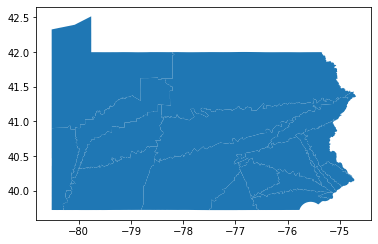

In [23]:
districts_df.plot()